# Contents
1. Import Libraries and Data
2. Wrangling the Data
3. Decomposition for Time Series Analysis
4. Testing for Stationarity
5. Stationarizing the Data

# 1. Import Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'jkhpFG_cqdB9QjPtrBiw'

In [3]:
# Importing the Yale Historical Housing Market Data - Consumer Price Index Annual variable.

data = quandl.get('YALE/CPIQ')

In [4]:
data.head(25)

,CPI
Date,
1890-12-31,7.611652
1891-12-31,7.801942
1892-12-31,7.326213
1893-12-31,7.897091
1894-12-31,6.850483
1895-12-31,6.565052
1896-12-31,6.660193
1897-12-31,6.469903
1898-12-31,6.660193


In [5]:
data.shape

(887, 1)

In [6]:
data.columns

Index(['CPI'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

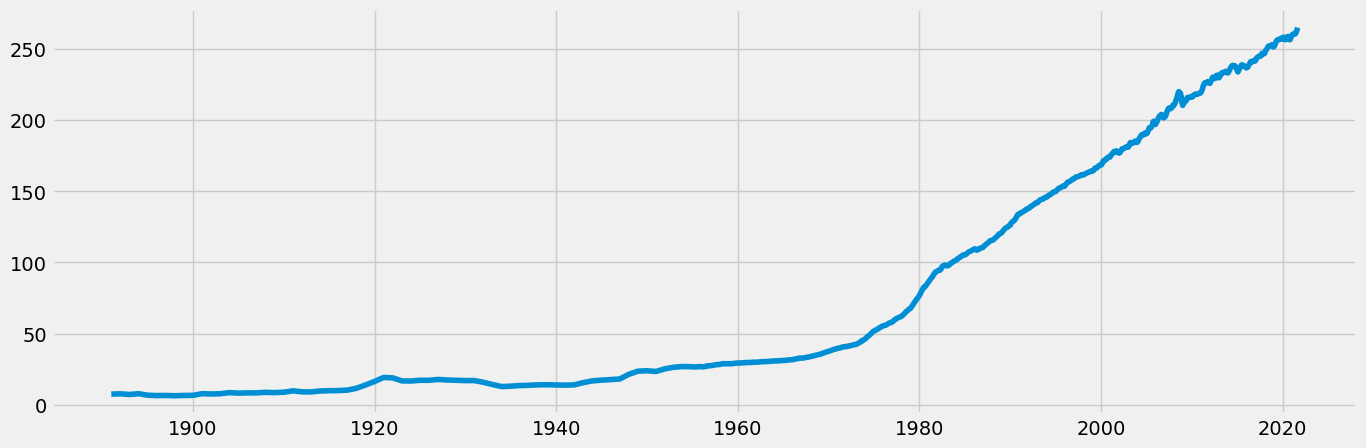

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

# 2. Wrangling the Data

In [9]:
# subsetting the data from 1990 to 2020 as the data from my main set is from 
#2017 only, so choosing data more relevant and closer to my main set
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-12-31')]

In [11]:
data_sub.shape

(491, 2)

In [12]:
data_sub.head()

,Date,CPI
387,1980-01-31,77.8
388,1980-02-29,78.9
389,1980-03-31,80.1
390,1980-04-30,81.0
391,1980-05-31,81.8


In [13]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,CPI
datetime,
1980-01-31,77.8
1980-02-29,78.9
1980-03-31,80.1
1980-04-30,81.0
1980-05-31,81.8


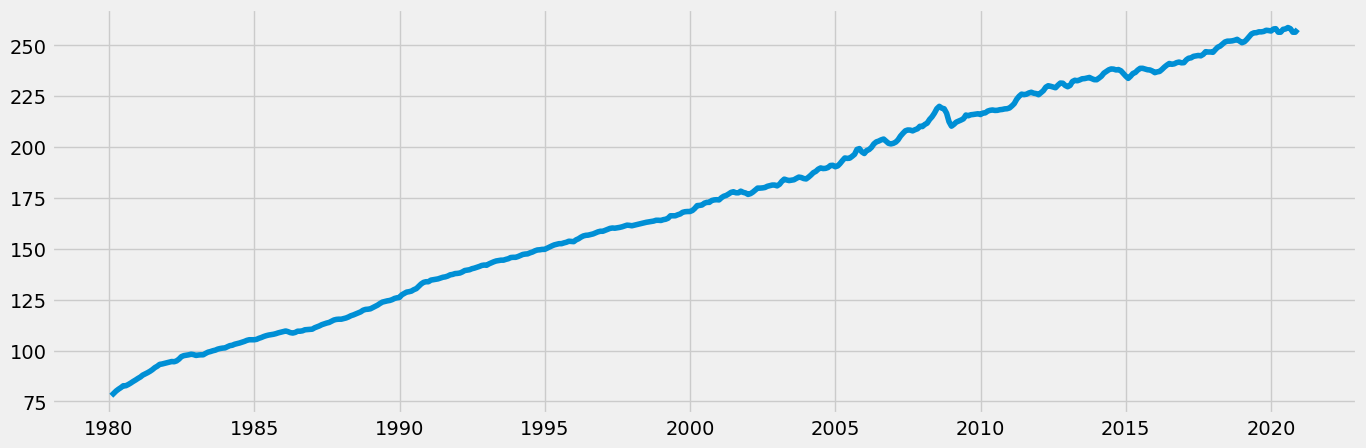

In [14]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [15]:
# Check for missing values 
data_sub.isnull().sum() 

CPI    0
dtype: int64

In [16]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

34

# 3. Decomposition for Time Series Analysis

In [17]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [18]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

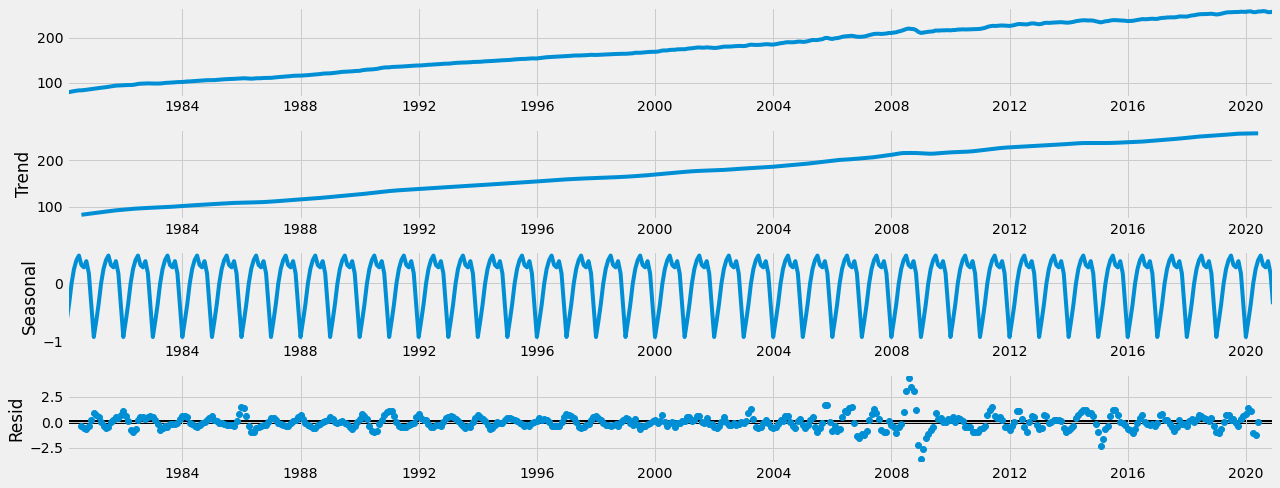

In [19]:
# Plot the separate components

decomposition.plot()
plt.show()

There is an obvious upward trend, which is no surprise. There is seasonality, also no surprise because moving during the winter is a special awfulness. There's steady noise except around 2008-2009 when the housing market bubble burst and we had a recession in the United States. 

# 4. Testing for Stationarity

In [20]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['CPI'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.793803
p-value                          0.820936
Number of Lags Used             13.000000
Number of Observations Used    477.000000
Critical Value (1%)             -3.444134
Critical Value (5%)             -2.867618
Critical Value (10%)            -2.570008
dtype: float64


The test statistic at -0.79 is larger than the Critical Value - all and we will need to stationarize the data to proceed.

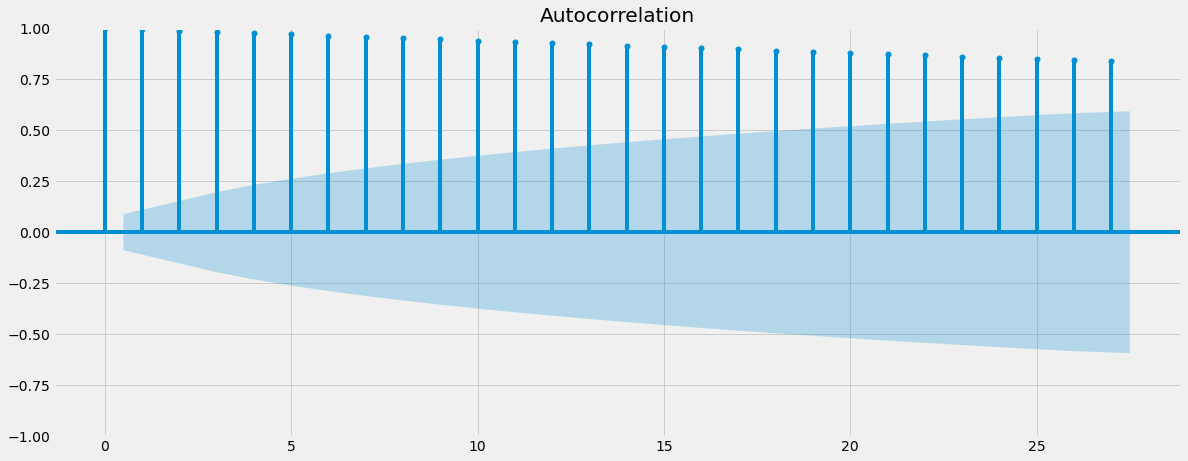

In [21]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

# 5. Stationarizing the Data

In [22]:
data_diff = data_sub - data_sub.shift(1)

In [23]:
data_diff.dropna(inplace = True)

In [24]:
data_diff.head()

,CPI
datetime,
1980-02-29,1.1
1980-03-31,1.2
1980-04-30,0.9
1980-05-31,0.8
1980-06-30,0.9


In [25]:
data_diff.columns

Index(['CPI'], dtype='object')

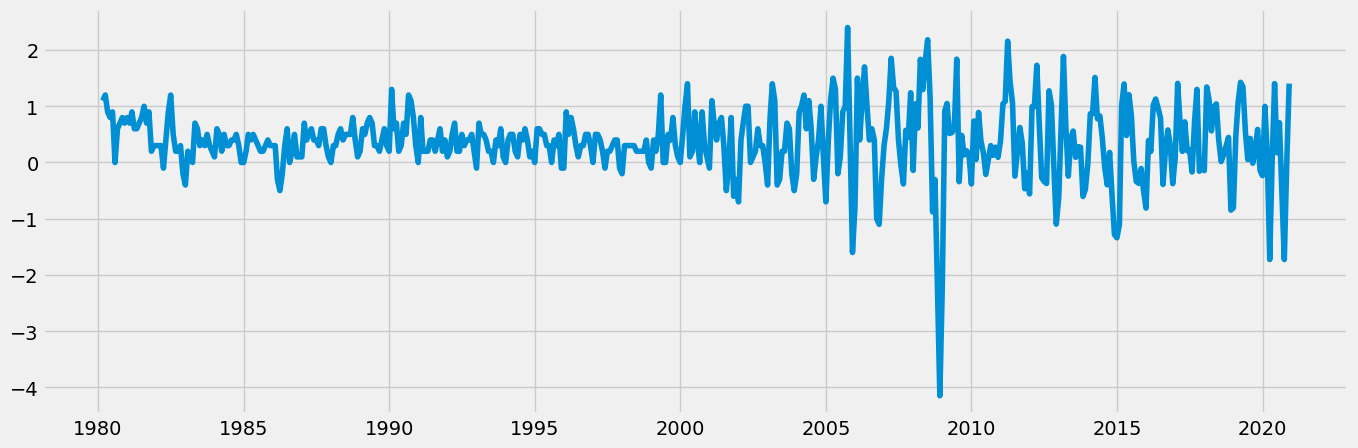

In [26]:
# Check what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [27]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.009406e+00
p-value                        1.586680e-07
Number of Lags Used            1.200000e+01
Number of Observations Used    4.770000e+02
Critical Value (1%)           -3.444134e+00
Critical Value (5%)           -2.867618e+00
Critical Value (10%)          -2.570008e+00
dtype: float64


The test statistic at -6.01 is now smaller than any of the Critical Values and is now considered stationary.

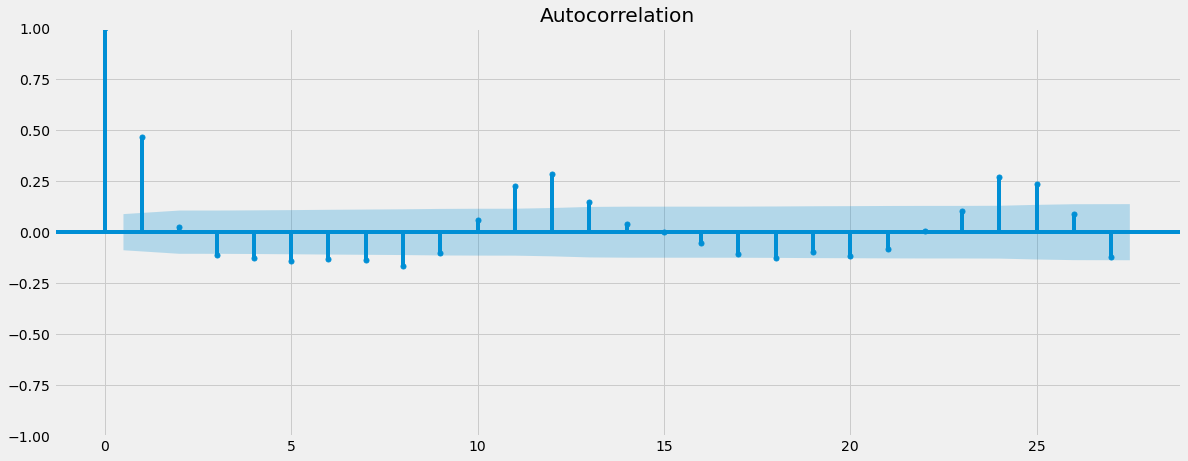

In [28]:
plot_acf(data_diff)
plt.show()